# Simple case: `KMeansScorer`

Let's have a closer look at the scorer's `window` parameter on the example of the `KmeansScorer`. We'll use two toy datasets to demonstrate how the scorers perform with different window sizes. In first example we set `window=1` on a multivariate time series, and in the second we set `window=2` on a univariate time series. 

The figure below illustrates the Scorer's windowing process:

<img src="../../images/ad_windowing.png" width="1000">

First, some necessary imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.ad import (
    ForecastingAnomalyModel,
    KMeansScorer,
    NormScorer,
    WassersteinScorer,
)
from darts.ad.utils import (
    eval_metric_from_scores,
    show_anomalies_from_scores,
)
from darts.dataprocessing.transformers import Scaler
from darts.datasets import TaxiNewYorkDataset
from darts.metrics import mae, rmse
from darts.models import RegressionModel

## Multivariate case with window=1 

### Synthetic data creation

The data is a multivariate series (2 components/columns). Each step has either value of `0` or `1`, and the two components always have opposite values:

In [2]:
pd.DataFrame(index=["State 1", "State 2"], data={"comp1": [0, 1], "comp2": [1, 0]})

,comp1,comp2
State 1,0,1
State 2,1,0


At each timestamp, it has a 50% chance to switch state and a 50% chance to keep the same state. 

#### Train set

In [3]:
def generate_data_ex1(random_state: int):
    np.random.seed(random_state)

    # create the train set
    comp1 = np.expand_dims(np.random.choice(a=[0, 1], size=100, p=[0.5, 0.5]), axis=1)
    comp2 = (comp1 == 0).astype(float)
    vals = np.concatenate([comp1, comp2], axis=1)
    return vals

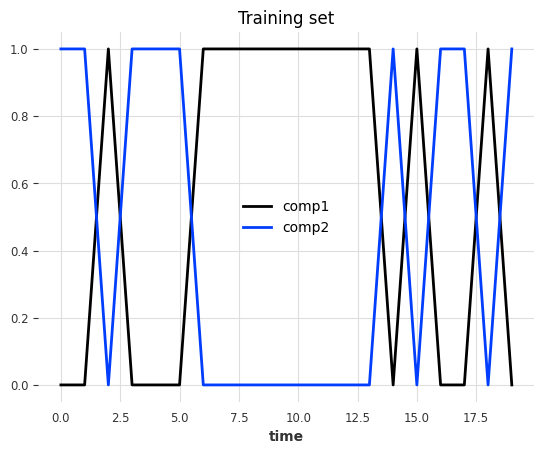

In [4]:
data = generate_data_ex1(random_state=40)
series_train = TimeSeries.from_values(data, columns=["comp1", "comp2"])

# visualize the train set
series_train[:20].plot()
plt.title("Training set")
plt.show()

#### Test set

We create the test set using the same rules as the train set but we'll inject six anomalies of three different types. The anomalies can be longer than one timestamp. The types are:

- 1st type: replacing the value of one component (0 or 1) with 2
- 2nd type: adding +1 or -1 to both components
- 3rd type: both components have the same value

In [5]:
# inject anomalies in the test timeseries
data = generate_data_ex1(random_state=3)

# 2 anomalies per type
# type 1: random values for only one component
data[20:21, 0] = 2
data[30:32, 1] = 2

# type 2: shift both components values (+/- 1 for both components)
data[45:47, :] += 1
data[60:64, :] -= 1

# type 3: switch one value to the another
data[75:82, 0] = data[75:82, 1]
data[90:96, 1] = data[90:96, 0]

series_test = TimeSeries.from_values(data, columns=["component 1", "component 2"])

# create the binary anomalies ground truth series
anomalies = ~((data == [0, 1]).all(axis=1) | (data == [1, 0]).all(axis=1))
anomalies = TimeSeries.from_times_and_values(
    times=series_test.time_index, values=anomalies, columns=["is_anomaly"]
)

Let's look at the anomalies. From left to right, the first two anomalies correspond to the first type, the third and the fourth correspond to the second type, and the last two to the third type.


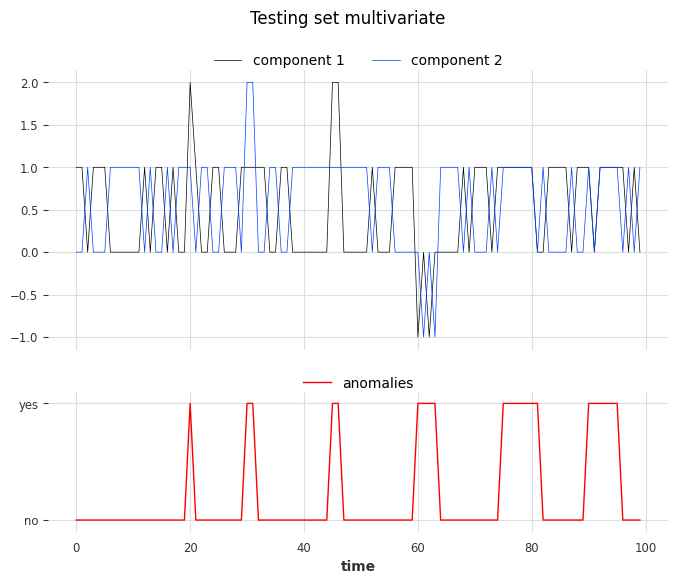

In [6]:
show_anomalies_from_scores(
    series=series_test, anomalies=anomalies, title="Testing set multivariate"
)

### Use the scorer `KMeansScorer()`

We'll use the `KMeansScorer` to locate the anomalies with the following parameters:

- `k`=2: The number of clusters/centroids generated by the KMeans model. We choose two since we know that there are only two valid states.
- `window`=1 (default): Each timestamp is considered independently by the KMeans model. It indicates the size of the window used to create the subsequences of the series (`window` is identical to a positive target `lag` for our [regression models](https://unit8co.github.io/darts/examples/20-RegressionModel-examples.html#Darts-Regression-Models)). In this example we know that each anomaly can be detected by only looking one step.
- `component_wise`=False (default): All components are used together as features with a single KMeans model. If `True`, we would fit a dedicated model per component. For this example we need information about both components to find all anomalies.

We'll fit `KMeansScorer` on the anomaly-free training series, compute the anomaly scores on the test series, and finally evaluate the scores.

In [7]:
Kmeans_scorer = KMeansScorer(k=2, window=1, component_wise=False)

# fit the KmeansScorer on the train timeseries 'series_train'
Kmeans_scorer.fit(series_train)

c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\subp

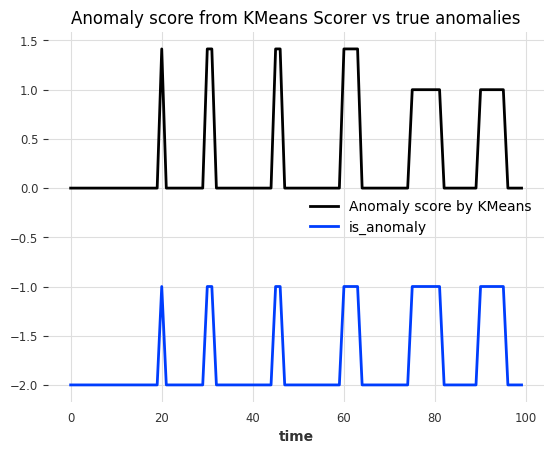

In [8]:
anomaly_score = Kmeans_scorer.score(series_test)

# visualize the anomaly score compared to the true anomalies
anomaly_score.plot(label="Anomaly score by KMeans")
(anomalies - 2).plot()
plt.title("Anomaly score from KMeans Scorer vs true anomalies")
plt.show()

Nice! We can see that the anomaly scores accurately indicate the position of the 6 anomalies.

To evaluate the scores, we can call `eval_metric()`. It expects the true anomalies, the series, and the name of the agnostic threshold metric (AUC-ROC or AUC-PR).

In [9]:
for metric_name in ["AUC_ROC", "AUC_PR"]:
    metric_val = Kmeans_scorer.eval_metric(anomalies, series_test, metric=metric_name)
    print(metric_name + f": {metric_val}")

AUC_ROC: 1.0
AUC_PR: 1.0


And again, let's visualize the results with `show_anomalies()`:

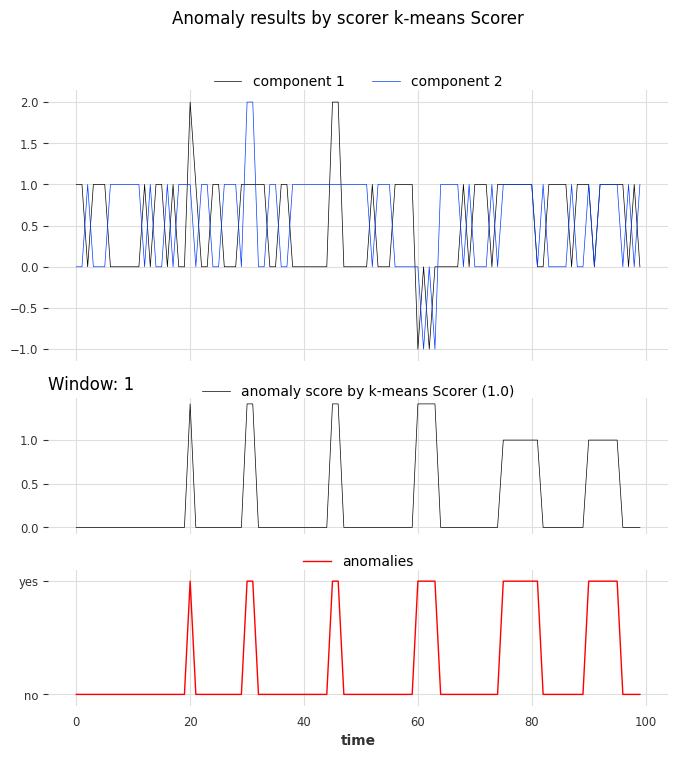

In [10]:
Kmeans_scorer.show_anomalies(series=series_test, anomalies=anomalies, metric="AUC_ROC")

## Univariate case with window>1 

In the previous example, we used `window=1` which was sufficient to identify all anomalies. In the next example, we'll see that sometimes higher values are required to capture the true anomalies.

### Synthetic data creation

#### Train set

In this toy example, we generate a univariate (one component) series that can take 4 possible values.

- possible values at each step `(0, 1, 2, 3)`
- every next step either adds `diff=+1` or subtracts `diff=-1` (50% chance)
- all steps are upper- and lower-bounded
  - `0` and `diff=-1` remains at `0`
  - `3` and `diff=+1` remains at `3`

In [11]:
def generate_data_ex2(start_val: int, random_state: int):
    np.random.seed(random_state)
    # create the test set
    vals = np.zeros(100)

    vals[0] = start_val

    diffs = np.random.choice(a=[-1, 1], p=[0.5, 0.5], size=len(vals) - 1)
    for i in range(1, len(vals)):
        vals[i] = vals[i - 1] + diffs[i - 1]
        if vals[i] > 3:
            vals[i] = 3
        elif vals[i] < 0:
            vals[i] = 0
    return vals

Text(0.5, 1.0, 'Training set')

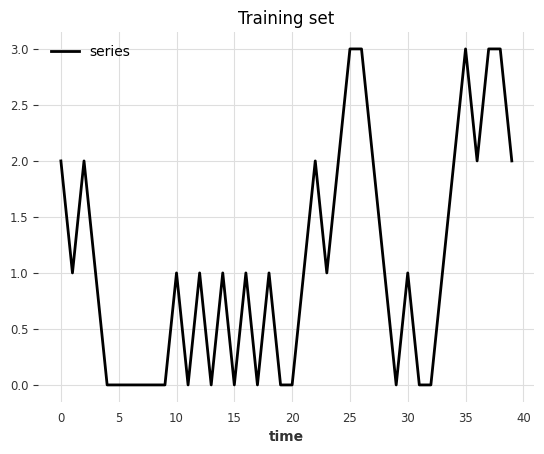

In [12]:
data = generate_data_ex2(start_val=2, random_state=1)
series_train = TimeSeries.from_values(data, columns=["series"])

# visualize the train set
series_train[:40].plot()
plt.title("Training set")

#### Test set

We create the test set using the same rules as the train set but we'll inject six anomalies of two different types. The anomalies can be longer than one timestamp:

- Type 1: steps with `abs(diff) > 1` (jumps larger than one)
- Type 2: steps with `diff = 0` at values `(1, 2)` (value remains constant)

In [13]:
data = generate_data_ex2(start_val=1, random_state=3)

# 3 anomalies per type
# type 1: sudden shift between state 0 to state 2 without passing by value 1
data[23] = 3
data[44] = 3
data[91] = 0

# type 2: having consecutive timestamps at value 1 or 2
data[3:5] = 2
data[17:19] = 1
data[62:65] = 2

series_test = TimeSeries.from_values(data, columns=["series"])

# identify the anomalies
diffs = np.abs(data[1:] - data[:-1])
anomalies = ~((diffs == 1) | ((diffs == 0) & np.isin(data[1:], [0, 3])))
# the first step is not an anomaly
anomalies = np.concatenate([[False], anomalies]).astype(int)

anomalies = TimeSeries.from_times_and_values(
    series_test.time_index, anomalies, columns=["is_anomaly"]
)

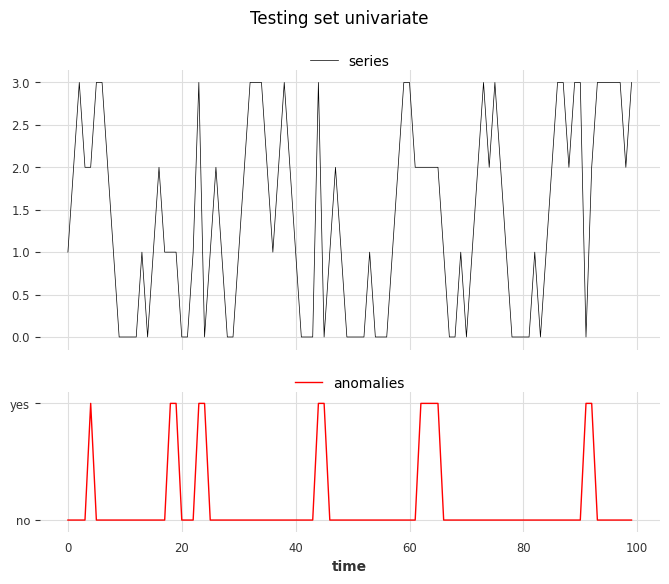

In [14]:
show_anomalies_from_scores(
    series=series_test, anomalies=anomalies, title="Testing set univariate"
)
plt.show()

From left to right, anomalies at positions 3, 4, and 6 are of type 1, and anomalies at positions 1, 2, and 5 are of type 2. 

### Use the scorer `KMeansScorer()`

We fit two `KMeansScorer` with different values for the `window` parameter (1 and 2).

In [15]:
windows = [1, 2]
Kmeans_scorer_w1 = KMeansScorer(k=4, window=windows[0])
Kmeans_scorer_w2 = KMeansScorer(k=8, window=windows[1], window_agg=False)

In [16]:
scores_all = []
metric_data = {"AUC_ROC": [], "AUC_PR": []}
for model, window in zip([Kmeans_scorer_w1, Kmeans_scorer_w2], windows):
    model.fit(series_train)
    scores = model.score(series_test)
    scores_all.append(scores)

    for metric_name in metric_data:
        metric_data[metric_name].append(
            eval_metric_from_scores(
                anomalies=anomalies,
                pred_scores=scores,
                metric=metric_name,
            )
        )
pd.DataFrame(data=metric_data, index=["w_1", "w_2"])

,AUC_ROC,AUC_PR
w_1,0.460212,0.123077
w_2,1.000000,1.000000


The metric indicates that the scorer with the parameter window set to 1 cannot locate the anomalies. On the other hand, the scorer with the parameter set to 2 perfectly identified the anomalies.

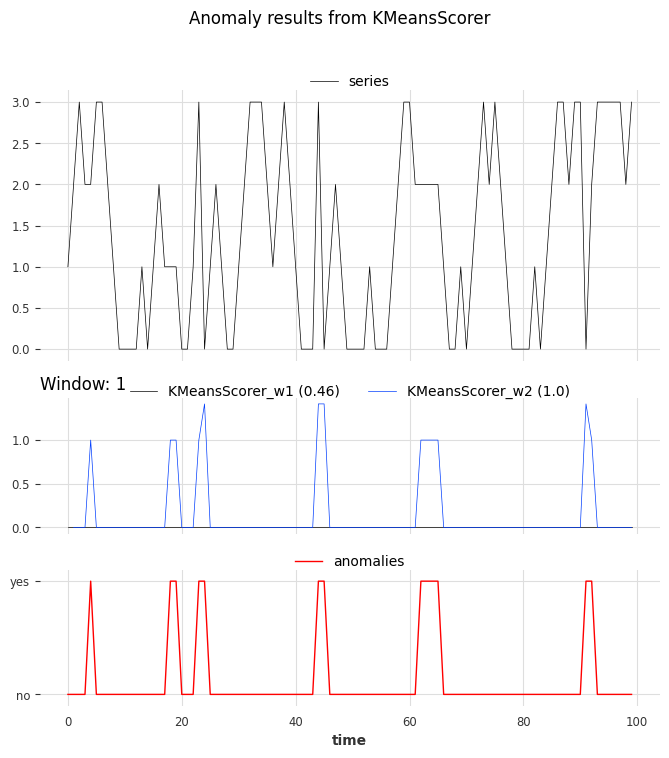

In [17]:
show_anomalies_from_scores(
    series=series_test,
    anomalies=anomalies,
    pred_scores=scores_all,
    names_of_scorers=["KMeansScorer_w1", "KMeansScorer_w2"],
    metric="AUC_ROC",
    title="Anomaly results from KMeansScorer",
)

We can see the accurate prediction of the scorer with a window of 2 compared to that of the scorer with a window of 1. 